# VIF Critic Training Notebook

This notebook provides an interactive environment for training and evaluating the VIF Critic model.

**What is the VIF Critic?**
- An MLP that predicts per-dimension Schwartz value alignment scores from journal entries
- Uses MC Dropout for uncertainty estimation
- Input: State vector (text embeddings + time gaps + history EMA + user profile)
- Output: 10-dim alignment scores in [-1, 1]

**Contents:**
1. Data Loading & Exploration
2. Model Architecture
3. Training Loop
4. Evaluation & Visualization
5. Ablation Studies

In [18]:
# Setup
import os
import sys
from pathlib import Path

# Change to project root so relative paths work correctly
# (notebook runs from notebooks/, data lives at project root)
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    os.chdir(notebook_dir.parent)
sys.path.insert(0, ".")

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import polars as pl
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device selection: CUDA > MPS (Apple Silicon) > CPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Using device: {device}")

Working directory: /Users/leongkaymei/Desktop/NUS-ISS/Capstone/twinkl
Using device: mps


## 1. Data Loading & Exploration

In [19]:
# Load raw data to explore
from src.vif.dataset import load_all_data, split_by_persona, merge_labels_and_entries

labels_df, entries_df = load_all_data()

print(f"Labels: {labels_df.shape}")
print(f"Entries: {entries_df.shape}")
print(f"Unique personas: {labels_df.select('persona_id').n_unique()}")

Labels: (740, 15)
Entries: (722, 8)
Unique personas: 102


In [20]:
# Examine label distribution
from src.models.judge import SCHWARTZ_VALUE_ORDER

merged_df = merge_labels_and_entries(labels_df, entries_df)

# Count alignment values per dimension
print("Alignment value distribution per dimension:")
print("=" * 50)
for dim in SCHWARTZ_VALUE_ORDER:
    col = f"alignment_{dim}"
    series = merged_df.select(col).to_series()
    counts = {v: (series == v).sum() for v in [-1, 0, 1]}
    print(f"{dim:15s}: -1={counts[-1]:3d}, 0={counts[0]:3d}, +1={counts[1]:3d}")

Alignment value distribution per dimension:
self_direction : -1=119, 0=328, +1=275
stimulation    : -1= 44, 0=582, +1= 96
hedonism       : -1= 89, 0=521, +1=112
achievement    : -1= 58, 0=453, +1=211
power          : -1= 65, 0=588, +1= 69
security       : -1=103, 0=487, +1=132
conformity     : -1= 96, 0=470, +1=156
tradition      : -1= 50, 0=520, +1=152
benevolence    : -1= 83, 0=350, +1=289
universalism   : -1=  5, 0=644, +1= 73


In [21]:
# Split data by persona
train_df, val_df, test_df = split_by_persona(labels_df, entries_df, seed=42)

print(
    f"Train: {len(train_df)} entries ({train_df.select('persona_id').n_unique()} personas)"
)
print(
    f"Val:   {len(val_df)} entries ({val_df.select('persona_id').n_unique()} personas)"
)
print(
    f"Test:  {len(test_df)} entries ({test_df.select('persona_id').n_unique()} personas)"
)

Train: 517 entries (70 personas)
Val:   95 entries (15 personas)
Test:  110 entries (15 personas)


## 2. Model Architecture

In [22]:
# Create encoder and state encoder
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder
from src.vif.critic import CriticMLP

# Use MiniLM for fast iteration (swap to mpnet for better quality)
text_encoder = SBERTEncoder("all-MiniLM-L6-v2")
print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")

state_encoder = StateEncoder(text_encoder, window_size=3, ema_alpha=0.3)
print(f"State dim: {state_encoder.state_dim}")

Encoder: all-MiniLM-L6-v2
Embedding dim: 384
State dim: 1174


In [23]:
# Create model
model = CriticMLP(
    input_dim=state_encoder.state_dim,
    hidden_dim=256,
    dropout=0.2,
)
model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(model)

Model parameters: 370,186
CriticMLP(
  (fc1): Linear(in_features=1174, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (gelu): GELU(approximate='none')
  (tanh): Tanh()
)


## 3. Training Loop

In [24]:
# Create datasets with embedding caching
from src.vif.dataset import VIFDataset
from torch.utils.data import DataLoader

print("Creating datasets (this caches embeddings)...")
train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Creating datasets (this caches embeddings)...


Batches: 100%|██████████| 4/4 [00:00<00:00, 24.71it/s]

Train batches: 33
Val batches: 6
Test batches: 7


In [25]:
# Training setup
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
)

# Training history
history = {"train_loss": [], "val_loss": [], "lr": []}

In [26]:
# Training loop
n_epochs = 100
best_val_loss = float("inf")
patience_counter = 0
early_stop_patience = 20

print("Training...")
for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            val_loss += criterion(pred, batch_y).item()
    val_loss /= len(val_loader)

    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    # Record history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["lr"].append(current_lr)

    # Check for improvement
    if val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "models/vif/notebook_best.pt")
        print(
            f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f} [BEST]"
        )
    else:
        patience_counter += 1
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f}"
            )

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print(f"\nBest validation loss: {best_val_loss:.4f}")

Training...
Epoch   1: train=0.3344, val=0.2615, lr=0.001000 [BEST]
Epoch   2: train=0.2901, val=0.2450, lr=0.001000 [BEST]
Epoch   3: train=0.2725, val=0.2285, lr=0.001000 [BEST]
Epoch   5: train=0.2636, val=0.2191, lr=0.001000 [BEST]
Epoch   8: train=0.2543, val=0.2166, lr=0.001000 [BEST]
Epoch   9: train=0.2508, val=0.2118, lr=0.001000 [BEST]
Epoch  11: train=0.2447, val=0.2169, lr=0.001000
Epoch  21: train=0.2310, val=0.2151, lr=0.000500
Early stopping at epoch 29

Best validation loss: 0.2118


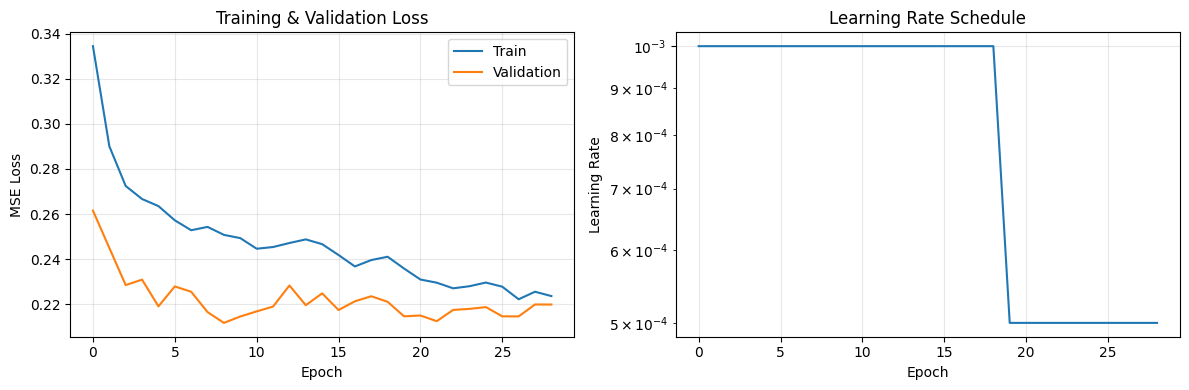

In [27]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history["lr"])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Learning Rate")
axes[1].set_title("Learning Rate Schedule")
axes[1].set_yscale("log")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Evaluation & Visualization

In [28]:
# Load best model
model.load_state_dict(torch.load("models/vif/notebook_best.pt", map_location=device))

# Evaluate with uncertainty
from src.vif.eval import evaluate_with_uncertainty, format_results_table

print("Evaluating on test set with MC Dropout...")
results = evaluate_with_uncertainty(model, test_loader, n_mc_samples=50, device=device)

print("\n" + format_results_table(results))

Evaluating on test set with MC Dropout...

Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3108      0.537     65.45%
stimulation              0.1802      0.397     84.55%
hedonism                 0.2426      0.168     76.36%
achievement              0.2801      0.390     69.09%
power                    0.0824      0.415     90.00%
security                 0.2996      0.483     61.82%
conformity               0.2469      0.377     71.82%
tradition                0.1769      0.435     76.36%
benevolence              0.3699      0.472     53.64%
universalism             0.0867      0.430     87.27%
----------------------------------------------------------------------
MEAN                     0.2276      0.410     73.64%

Calibration:
  Error-uncertainty correlation: -0.109
  Mean uncertainty: 0.0736


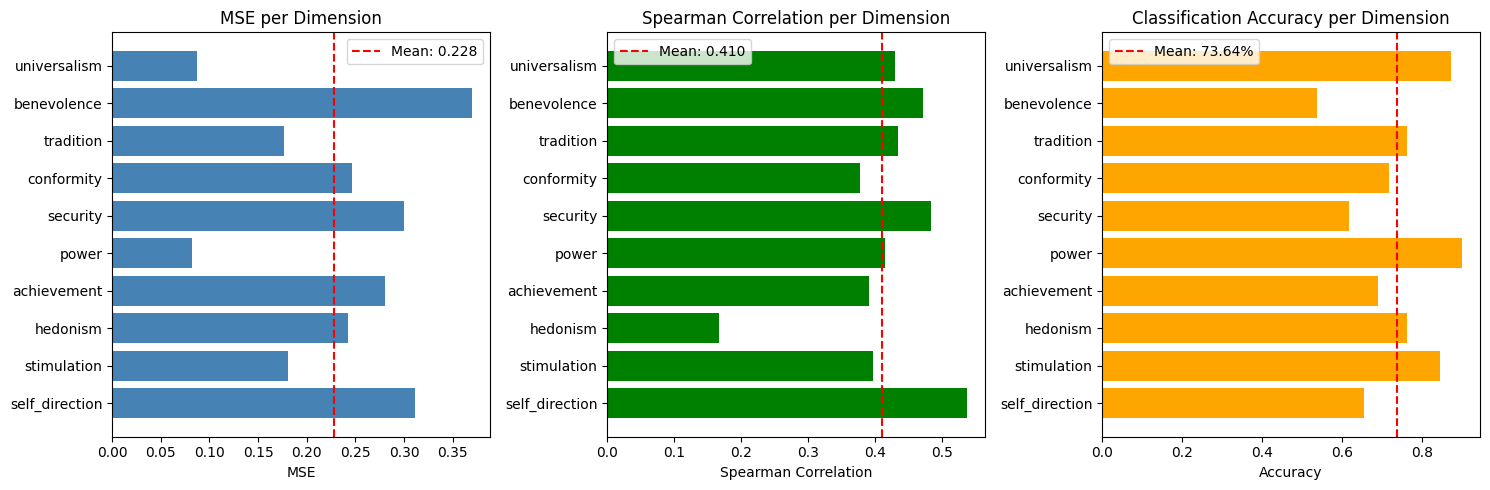

In [29]:
# Visualize per-dimension performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MSE per dimension
dims = list(results["mse_per_dim"].keys())
mse_vals = list(results["mse_per_dim"].values())
axes[0].barh(dims, mse_vals, color="steelblue")
axes[0].set_xlabel("MSE")
axes[0].set_title("MSE per Dimension")
axes[0].axvline(
    results["mse_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['mse_mean']:.3f}",
)
axes[0].legend()

# Spearman correlation per dimension
spearman_vals = [results["spearman_per_dim"][d] for d in dims]
colors = ["green" if v > 0 else "red" for v in spearman_vals]
axes[1].barh(dims, spearman_vals, color=colors)
axes[1].set_xlabel("Spearman Correlation")
axes[1].set_title("Spearman Correlation per Dimension")
axes[1].axvline(
    results["spearman_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['spearman_mean']:.3f}",
)
axes[1].legend()

# Accuracy per dimension
acc_vals = [results["accuracy_per_dim"][d] for d in dims]
axes[2].barh(dims, acc_vals, color="orange")
axes[2].set_xlabel("Accuracy")
axes[2].set_title("Classification Accuracy per Dimension")
axes[2].axvline(
    results["accuracy_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['accuracy_mean']:.2%}",
)
axes[2].legend()

plt.tight_layout()
plt.show()

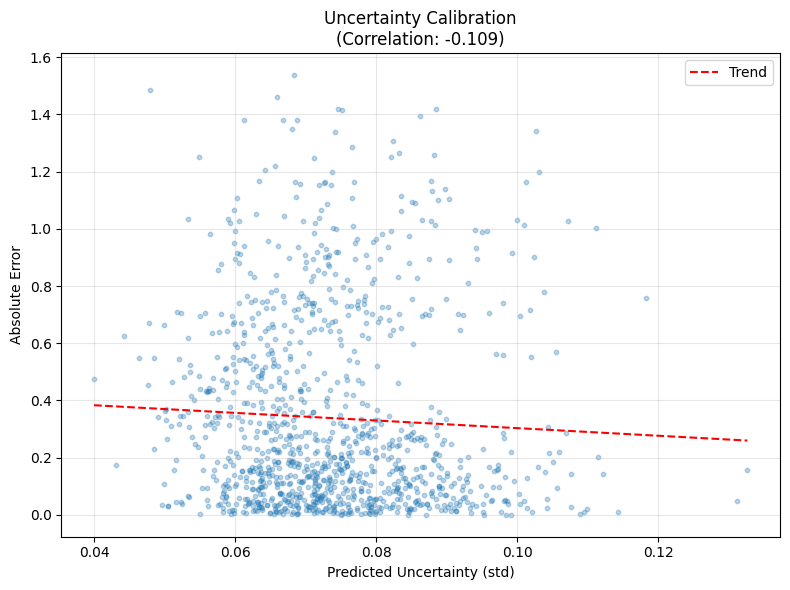

In [30]:
# Uncertainty calibration check
# If well-calibrated, higher uncertainty should correlate with higher error
errors = np.abs(results["predictions"] - results["targets"]).flatten()
uncertainties = results["uncertainties"].flatten()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(uncertainties, errors, alpha=0.3, s=10)
ax.set_xlabel("Predicted Uncertainty (std)")
ax.set_ylabel("Absolute Error")
ax.set_title(
    f"Uncertainty Calibration\n(Correlation: {results['calibration']['error_uncertainty_correlation']:.3f})"
)

# Add trend line
z = np.polyfit(uncertainties, errors, 1)
p = np.poly1d(z)
x_line = np.linspace(uncertainties.min(), uncertainties.max(), 100)
ax.plot(x_line, p(x_line), "r--", label="Trend")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Ablation Studies

Try different configurations and compare results.

In [31]:
# Quick ablation: compare encoder models
# Uncomment to run (takes a few minutes per encoder)

# from src.vif.train import train, load_config
#
# encoders_to_test = [
#     'paraphrase-MiniLM-L3-v2',  # Fastest, lower quality
#     'all-MiniLM-L6-v2',          # Default balance
#     # 'all-mpnet-base-v2',       # Higher quality, slower
# ]
#
# ablation_results = {}
# for encoder_name in encoders_to_test:
#     print(f'\n{"="*60}')
#     print(f'Testing encoder: {encoder_name}')
#     print('=' * 60)
#
#     config = load_config('config/vif.yaml')
#     config['encoder']['model_name'] = encoder_name
#     config['training']['epochs'] = 50  # Shorter for ablation
#
#     results = train(config, verbose=False)
#     ablation_results[encoder_name] = results['test_results']
#
#     print(f"MSE: {results['test_results']['mse_mean']:.4f}")
#     print(f"Spearman: {results['test_results']['spearman_mean']:.4f}")

In [32]:
# Summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Encoder: {text_encoder.model_name}")
print(f"State dim: {state_encoder.state_dim}")
print(f"Model params: {n_params:,}")
print(f"Best val loss: {best_val_loss:.4f}")
print(f"Test MSE: {results['mse_mean']:.4f}")
print(f"Test Spearman: {results['spearman_mean']:.4f}")
print(f"Test Accuracy: {results['accuracy_mean']:.2%}")
print("=" * 60)


TRAINING SUMMARY
Encoder: all-MiniLM-L6-v2
State dim: 1174
Model params: 370,186
Best val loss: 0.2118
Test MSE: 0.2276
Test Spearman: 0.4104
Test Accuracy: 73.64%


## 6. Future Work: Loss Function Considerations

The current implementation uses **MSE (Mean Squared Error)** as the training loss, treating discrete alignment labels `{-1, 0, +1}` as continuous regression targets. This section documents the trade-offs and potential alternatives to explore.

---

### ✅ Why MSE Works

1. **Continuous output is useful downstream**
   - Drift detection metrics (Section 3 of `VIF_06`) use continuous alignment scores, not discrete classes
   - A prediction of `-0.7` vs `-0.3` carries meaningful signal for profile-weighted misalignment calculations
   - `Tanh` activation naturally outputs continuous values in `[-1, 1]`

2. **Simple and stable optimization**
   - MSE is convex, well-understood, and numerically stable
   - No need to handle class weights or logit scaling

3. **Preserves ordinal structure implicitly**
   - MSE penalizes predicting `+1` when truth is `-1` more than predicting `0`
   - The loss surface naturally respects the ordering `-1 < 0 < +1`

---

### ⚠️ Why MSE Is Questionable

1. **Class imbalance is ignored**
   - From our label distribution: `stimulation` has 202 neutral vs 11 non-neutral
   - MSE optimizes average error — predicting `0` for everyone on rare-class dimensions is rewarded
   - Result: 100% accuracy on `stimulation` but `N/A` Spearman (no variance in predictions)

2. **Treats all errors equally within magnitude**
   - Misclassifying `-1 → 0` costs the same as `0 → +1`
   - But semantically, confusing "misaligned" with "aligned" may be worse than "neutral" errors

3. **No calibration incentive**
   - MSE doesn't encourage the model to output predictions near `{-1, 0, +1}`
   - Predictions cluster around `0` to minimize average squared error

4. **Discrete ground truth**
   - Judge labels are fundamentally categorical: misaligned / neutral / aligned
   - Regression assumes continuous underlying signal that may not exist

---

### 🔬 TODO: Alternatives to Explore

- [ ] **Cross-entropy with 3 classes**: Treat as classification, output logits for `{-1, 0, +1}`
- [ ] **Ordinal regression**: Use cumulative link models that respect `-1 < 0 < +1` ordering
- [ ] **Class-weighted MSE**: Weight rare classes (e.g., `stimulation ≠ 0`) higher in loss
- [ ] **Focal loss**: Down-weight easy examples (the many `0`s), focus on hard cases
- [ ] **Hybrid loss**: MSE for continuous signal + cross-entropy for class boundaries

### 📊 Evaluation Criteria for Comparison

When comparing loss functions, track:
- **Per-dimension accuracy** (especially on imbalanced dimensions like `stimulation`, `power`)
- **Spearman correlation** (does ranking quality improve?)
- **Calibration** (do predictions cluster near true classes?)
- **Downstream drift detection** (does the alternative improve profile-weighted misalignment signals?)